# Part II - (Airline On-Time Performance)
## by (Eloebhose Kingsley Osazele)

## Investigation Overview


**In this investigation , I was Interested in finding out about:**

- What major factors are causing flights arrival and departure delay?
- Is distance a major determinants of delayed flights?
- Are flights delay due to the unique carriers?
- Are they any other interesting patterns that affected delayed flights? 


## Dataset Overview

The dataset contains about 2.4 millions records and 29 columns, although during the preliminary wrangling section of this project, the dataset was assessed to check for quality and tidiness issues. This led us to create new columns for the Origin and Dest columns named Origin1 and Destination which is more descriptive than the origin column. Same thing was done for the Unique Carrier columns, which was now named Airlines. The variables in the dataset are mainly numerical with some categorical variables like CancellationCode.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
airline_df = pd.read_csv('2008.csv.bz2')

In [5]:
# load the airport dataset and the carriers dataset, this will be used to replace the IATA code
# with the airport name and the carrier name
airport_df = pd.read_csv('airports.csv')
carriers_df = pd.read_csv('carriers.csv')

print(airport_df.head())

print(carriers_df.head())

  iata               airport
0  00M              Thigpen 
1  00R  Livingston Municipal
2  00V           Meadow Lake
3  01G          Perry-Warsaw
4  01J      Hilliard Airpark
  Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.


In [6]:
Airline_copy = airline_df.copy()

In [7]:
# create full_date column
Airline_copy['Date'] = pd.to_datetime(dict(year=Airline_copy.Year, month=Airline_copy.Month, 
                                           day=Airline_copy.DayofMonth))

In [8]:
Airline_copy['Cancelled'] = Airline_copy['Cancelled'].replace([1, 0], ["Cancelled", "Not Cancelled"])
Airline_copy['Diverted'] = Airline_copy['Diverted'].replace([1, 0], ["Diverted", "Not Diverted"])

In [9]:
# Changing the Cancelled column data type to ordered categorical
Cancelled_classes = ['Cancelled','Not Cancelled']
Cancelled_ordered_new = pd.api.types.CategoricalDtype(ordered=True,categories=Cancelled_classes)
Airline_copy['Cancelled']=Airline_copy['Cancelled'].astype(Cancelled_ordered_new)

In [10]:
# Changing the Diverted column data type to ordered categorical
Diverted_classes = ['Diverted','Not Diverted']
Diverted_ordered_new = pd.api.types.CategoricalDtype(ordered=True,categories=Diverted_classes)
Airline_copy['Diverted']=Airline_copy['Diverted'].astype(Diverted_ordered_new)

In [11]:
# change columns  'Year', 'Month', 'DayofMonth', 'DayofWeek' to string
Airline_copy[Airline_copy.columns[0:4]] = Airline_copy[Airline_copy.columns[0:4]].astype(object)

In [12]:
# Fill the null values in the CancellationCode Column with "N" where "N" represents the null values
# Since it is assumed that the null values in these columns represent flights that did not cancel
# their Flights, hence they don't have any cancellation reason.
Airline_copy.CancellationCode.fillna('N', inplace=True)

In [13]:
Airline_copy.CarrierDelay.fillna(0, inplace=True)
Airline_copy.WeatherDelay.fillna(0, inplace=True)
Airline_copy.NASDelay.fillna(0, inplace=True)
Airline_copy.SecurityDelay.fillna(0, inplace=True)
Airline_copy.LateAircraftDelay .fillna(0, inplace=True)

In [14]:
# Null values imputation of columns relating to Arrival,Departure, TimeIn &Timeout using interpolation
Airline_copy['DepTime'] = Airline_copy['DepTime'].interpolate(method='linear', limit_direction='both', axis=0) 
Airline_copy['ArrTime'] = Airline_copy['ArrTime'].interpolate(method='linear', limit_direction='both', axis=0) 

Airline_copy['ActualElapsedTime'] = Airline_copy['ActualElapsedTime'].interpolate(method='linear', limit_direction ='both', axis=0) 
Airline_copy['CRSElapsedTime'] = Airline_copy['CRSElapsedTime'].interpolate(method='linear', limit_direction ='both', axis=0)

Airline_copy['AirTime'] = Airline_copy['AirTime'].interpolate(method='linear', limit_direction ='both', axis=0) 
Airline_copy['ArrDelay'] = Airline_copy['ArrDelay'].interpolate(method='linear', limit_direction ='both', axis=0) 
Airline_copy['DepDelay'] = Airline_copy['DepDelay'].interpolate(method='linear', limit_direction ='both', axis=0)

Airline_copy['TaxiIn'] = Airline_copy['TaxiIn'].interpolate(method='linear', limit_direction ='both', axis=0) 
Airline_copy['TaxiOut'] = Airline_copy['TaxiOut'].interpolate(method='linear', limit_direction ='both', axis=0)

In [15]:
# we are going to combine the various columns that documents the reasons for delay into one columns. 
# This would makes our analyses easier
Airline_copy = pd.melt(Airline_copy,id_vars=['Date','Year','Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime',
                    'UniqueCarrier','FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','AirTime',
                    'ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled',
                    'CancellationCode', 'Diverted'], value_vars=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
                                                                 'LateAircraftDelay'],
       var_name='ReasonsForDelay', value_name='DelayInMinutes')

In [17]:
#drop duplicated values 
Airline_copy = Airline_copy.drop_duplicates()

In [16]:
# join the carrier dataset with the airline dataset
Airline_copy=Airline_copy.merge(carriers_df, how='inner', left_on='UniqueCarrier', right_on='Code')
Airline_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11946085 entries, 0 to 11946084
Data columns (total 29 columns):
Date                 datetime64[ns]
Year                 object
Month                object
DayofMonth           object
DayOfWeek            object
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            category
CancellationCode     object
Diverted             category
ReasonsForDelay      object
DelayInMinutes       float64
Code                 object
Description          object
dtypes: category(2), datetime64[ns](1), float64(10), in

In [18]:
# The Code column will be dropped, since it is the same as the Unique Carrier column 
# and  Descrioption column will be replaced with Airlines
Airline_copy.drop(columns=['Code'], axis=1, inplace=True)
Airline_copy.rename(columns={'Description': 'Airlines'}, inplace=True)

In [19]:
# join the airport name(Origin) dataset with the Airlines_Copy dataframe
Airline_copy=Airline_copy.merge(airport_df, how='inner', left_on='Origin', right_on='iata')
Airline_copy.drop(columns=['iata'], axis=1, inplace=True)
Airline_copy.rename(columns={'airport': 'Origin1'}, inplace=True)

In [20]:
# join the airport name(Destination) dataset with the Airlines_Copy dataframe
Airline_copy=Airline_copy.merge(airport_df, how='inner', left_on='Dest', right_on='iata')
Airline_copy.drop(columns=['iata'], axis=1, inplace=True)
Airline_copy.rename(columns={'airport': 'Destination'}, inplace=True)

In [21]:
#Create the ArrDelay1 column from existing column ArrDelay
ArrDelay1=[]

for row in Airline_copy['ArrDelay']:
    if row < 15 :    ArrDelay1.append('OnTime')
    else:            ArrDelay1.append('Late')
        

Airline_copy['ArrDelay1']=ArrDelay1

In [22]:
#Create the DepDelay1 column from existing column DepDelay
DepDelay1=[]

for row in Airline_copy['DepDelay']:
    if row < 15 :    DepDelay1.append('OnTime')
    else:            DepDelay1.append('Late')
        

Airline_copy['DepDelay1']=DepDelay1

## (Departure Delay)

The main object of the Airline Ontime Performance project was to know the major causes of the delays. So first of all we need to know how many percent of flights were delayed and what is their value. This is shown using a barchart and a pie chart.

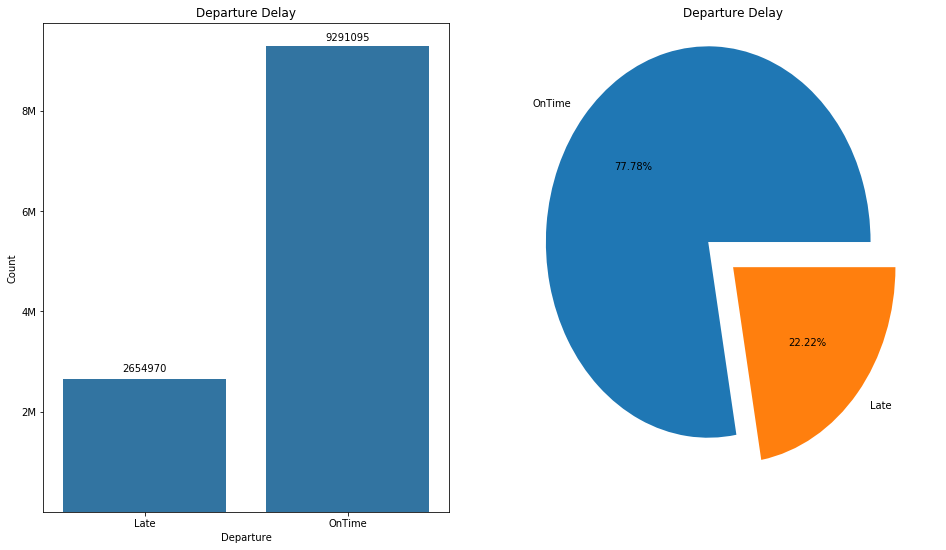

In [24]:
# Create a barchart and a piechart that shows the value and percentage of Departure Delays
plt.figure(figsize=[16,9])
plt.subplot(1,2,1)
base_color=sb.color_palette()[0]
sb.countplot(data=Airline_copy, x='DepDelay1',color=base_color);
plt.text(0,2800000,2654970, ha='center')
plt.text(1,9400000,9291095, ha='center')
plt.yticks([2000000,4000000,6000000,8000000], ['2M','4M','6M','8M'])
plt.xlabel('Departure');
plt.ylabel('Count');
plt.title('Departure Delay');

# Create a variable that store the value_counts of Depature Delays
df=Airline_copy.DepDelay1.value_counts()
plt.subplot(1,2,2);
plt.pie(x=df, labels=df.index, explode=(0.2, 0), autopct='%.2f%%');
plt.title('Departure Delay');

## (Arrival Delay)

The main object of the Airline Ontime Performance project was to know the major causes of the delays. So we need to also know how many percent of flights had arrival delay greater than 15 minutes(Late) and how many flights had arrival delay less than 15 minutes(OnTime) and what is their value. This is shown using a barchart and a pie chart.

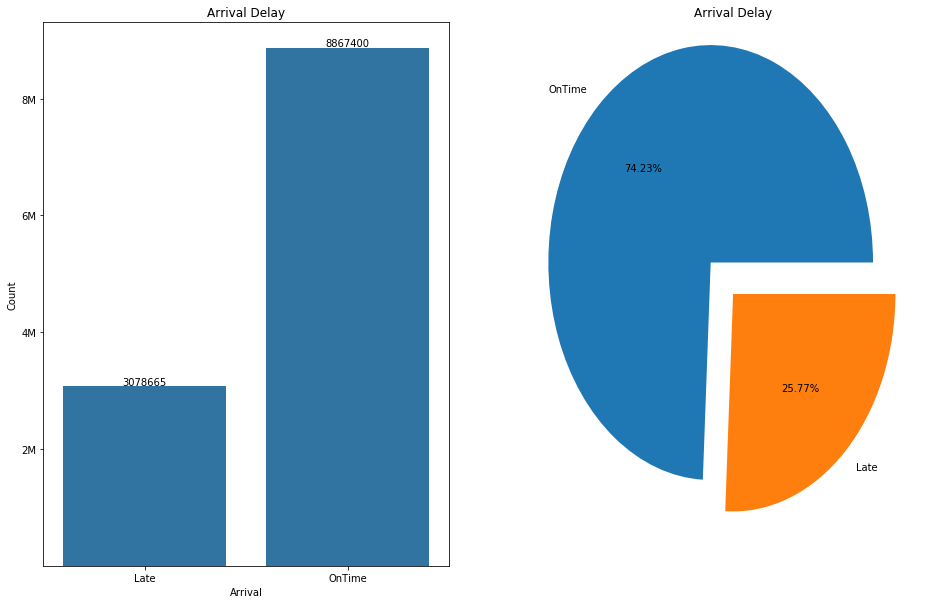

In [25]:
# Create a barchart and a piechart that shows the value and percentage of Arrival Delays
plt.figure(figsize=[16,10])
plt.subplot(1,2,1)
base_color=sb.color_palette()[0]
sb.countplot(data=Airline_copy, x='ArrDelay1',color=base_color);
plt.text(0,3100000,3078665, ha='center')
plt.text(1,8900000,8867400, ha='center')
plt.yticks([2000000,4000000,6000000,8000000], ['2M','4M','6M','8M'])
plt.xlabel('Arrival');
plt.ylabel('Count');
plt.title('Arrival Delay');

# Create a variable that store the value_counts of Arrival Delays
df=Airline_copy.ArrDelay1.value_counts()
plt.subplot(1,2,2);
plt.pie(x=df, labels=df.index, explode=(0.2, 0), autopct='%.2f%%');
plt.title('Arrival Delay');

## (Reasons For Delay)

After investigating to know that only 22.22% of flights departed late(15 minutes after the scheduled time of departure) and 22.77% of flights arrived late(15 minutes after the scheduled time of arrival), we looked futher to investigate what was causing this delay using a bar chart to plot the results.



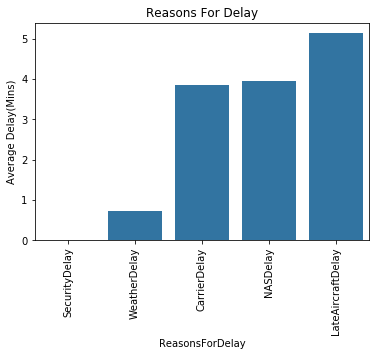

In [26]:
delay = Airline_copy.groupby('ReasonsForDelay')['DelayInMinutes'].mean()
delay=delay.sort_values()
x= delay.index
y=delay.values

# Create a barchart that shows the average reasons for delay through the year 2008
base_color=sb.color_palette()[0]
sb.barplot(x=x, y=y, color=base_color)
plt.xticks(rotation=90)
plt.ylabel('Average Delay(Mins)')
plt.title('Reasons For Delay')
plt.show()

## (Average Arrival Delay of Airlines)
Next, let us see the Average Arrival Delay of each Airlines for the year 2008.


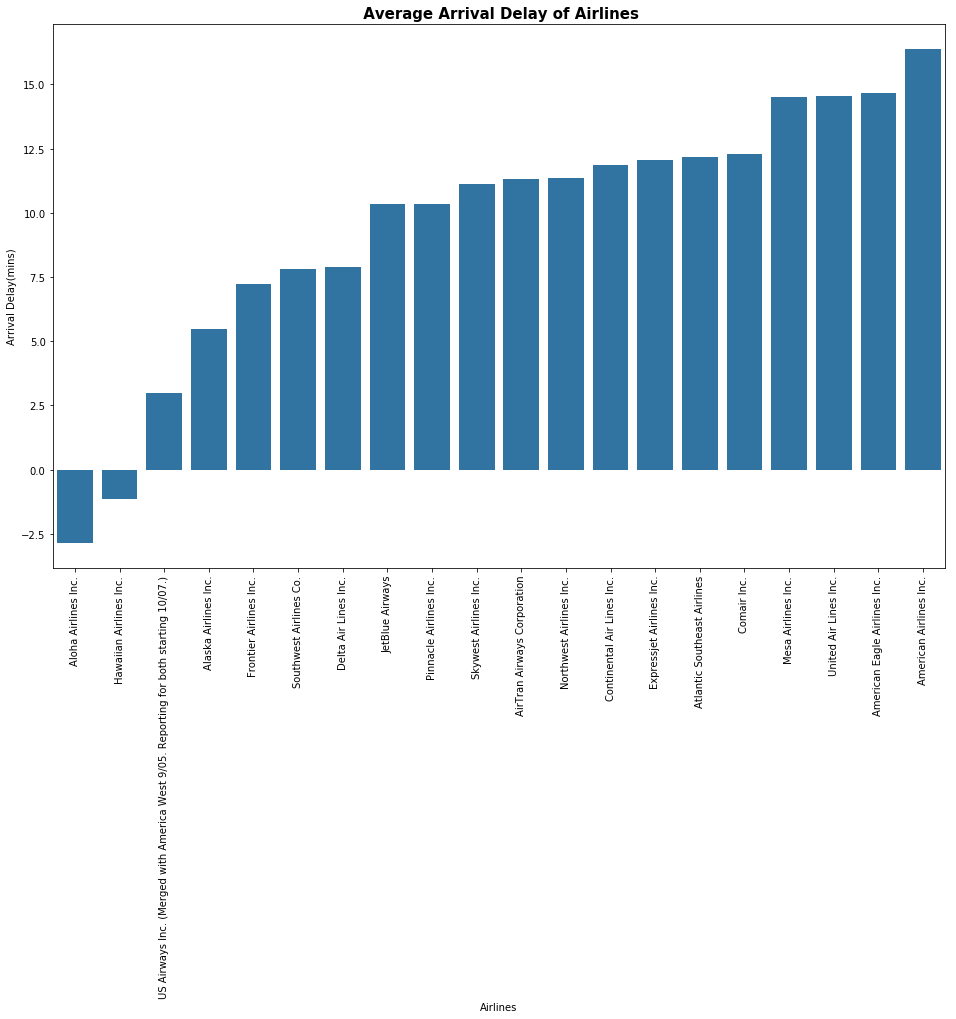

In [27]:
# Create a dataframe that stores the average Arrival Delay by Airlines
dff1=Airline_copy.groupby('Airlines').mean()['ArrDelay'].sort_values()
# Create a barchart that shows the relation between Airlines and Arrival Delay
base_color=sb.color_palette()[0]
plt.figure(figsize=[16,10])
sb.barplot(y=dff1.values, x=dff1.index, color=base_color)
plt.ylabel('Arrival Delay(mins)')
plt.xlabel('Airlines')
plt.title(' Average Arrival Delay of Airlines', size=15, weight='bold')
plt.xticks(rotation=90)
plt.show()

## (Average Departure Delay of Airlines)
Next, let us see the Average Departure Delay of each Airlines for the year 2008.

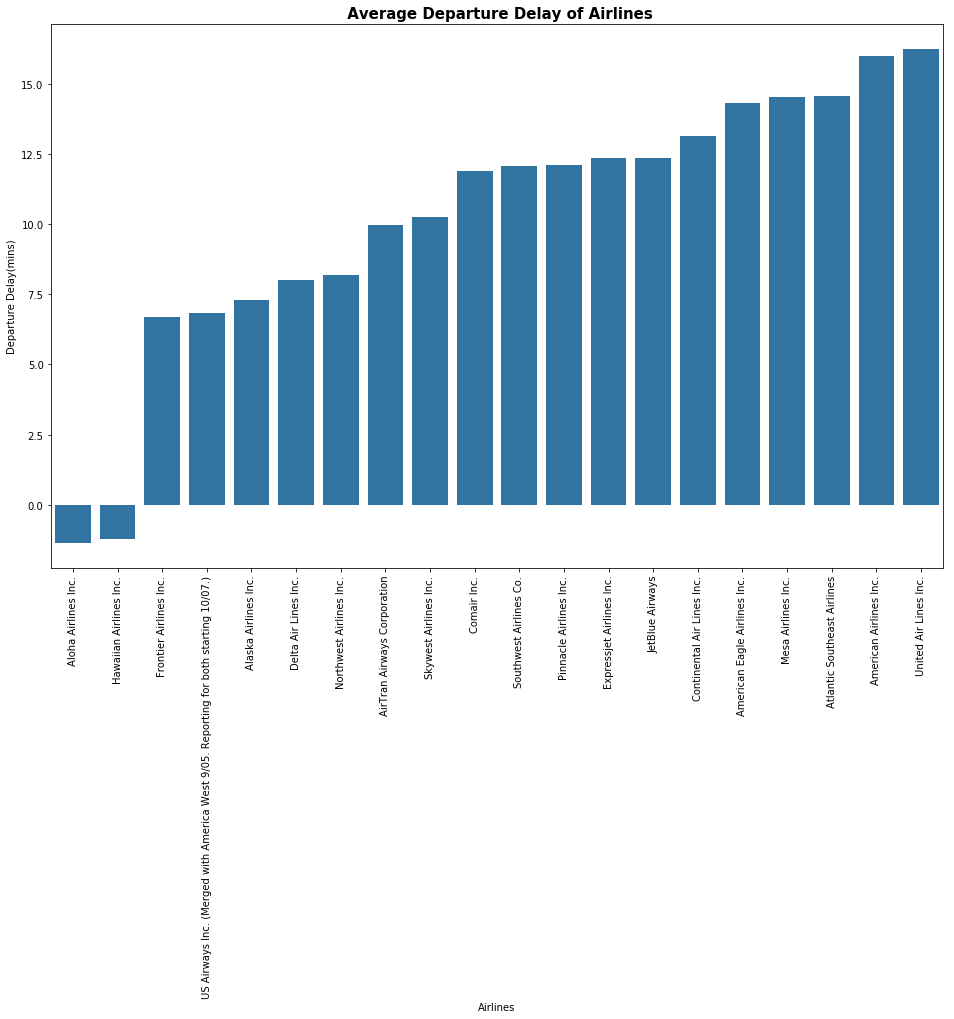

In [28]:
# Create a dataframe that stores the average Departure Delay by Airlines
dff2=Airline_copy.groupby('Airlines').mean()['DepDelay'].sort_values()
# Create a barchart that shows the relation between Airlines and Departure Delay
base_color=sb.color_palette()[0]
plt.figure(figsize=[16,10])
sb.barplot(y=dff2.values, x=dff2.index, color=base_color)
plt.ylabel('Departure Delay(mins)')
plt.xlabel('Airlines')
plt.title(' Average Departure Delay of Airlines', size=15, weight='bold')
plt.xticks(rotation=90)
plt.show()

## (Reasons For Delay For United Airlines and American Airlines inc)
 
After using the Adapted bar chart to investigate the relation between Airlines and Arrival and Departure Delay variables, we decided to look futher into the reasons for United Airlines inc. and American Airlines inc having delayed flights.  

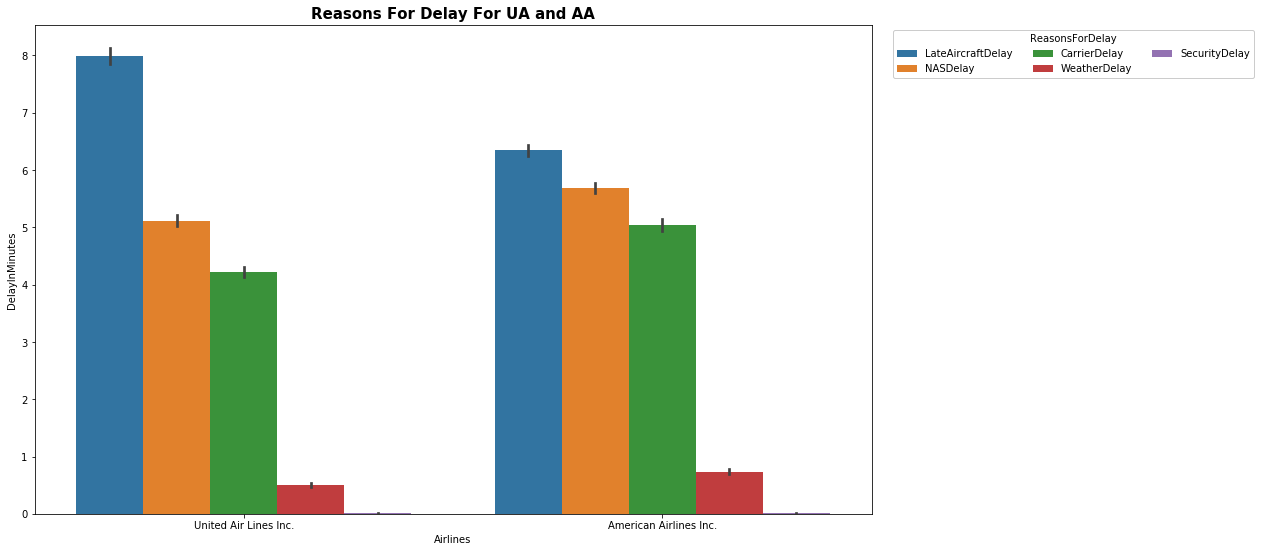

In [29]:
subset = Airline_copy.query('(UniqueCarrier == "UA") | (UniqueCarrier == "AA")')
# Use an Adaptation of the clustered bar chart to Show the Reasons For Delay for 
# United AirLines inc and American Airlines inc.
plt.figure(figsize=[15,9])
ax=sb.barplot(data=subset, x='Airlines', y='DelayInMinutes', hue='ReasonsForDelay',
             hue_order=['LateAircraftDelay', 'NASDelay', 'CarrierDelay', 'WeatherDelay', 'SecurityDelay'])
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, framealpha=1, title='ReasonsForDelay')
plt.title('Reasons For Delay For UA and AA', size=15, weight='bold')
plt.show()

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

> In the classroom workspace, the generated HTML slideshow will be placed in the home folder. 

> In local machines, the command above should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 